In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train,Y_train), (X_test,y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape # 60000 images in 28x28 pixels

(60000, 28, 28)

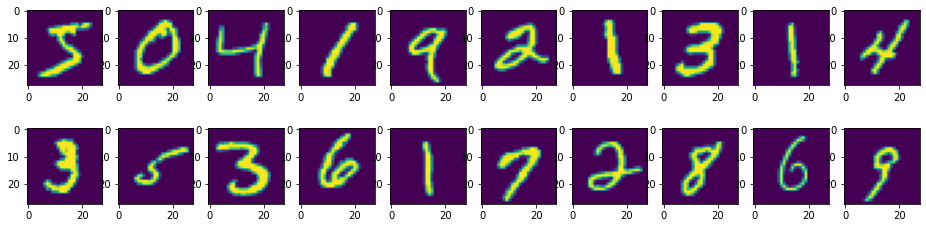

In [ ]:
# show some images

row = 2
column = 10

fig, axes = plt.subplots(row, column, figsize=(16,4))

count = 0
for i in range(row):
  for j in range(column):
    axes[i,j].imshow(X_train[count])
    count+=1

In [ ]:
# Normalization


X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
noise_factor = 0.2

X_train_noise = X_train + noise_factor * np.random.normal(loc=0., scale=1., size=X_train.shape) # loc is mean, scale= standard deviation, size is outshape
X_test_noise = X_test + noise_factor * np.random.normal(loc=0., scale=1., size=X_test.shape)

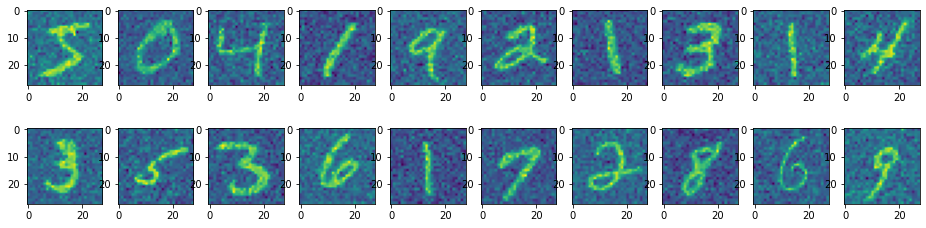

In [ ]:
row = 2
column = 10

fig, axes = plt.subplots(row, column, figsize=(16,4))

# plot noisy images
count = 0
for i in range(row):
  for j in range(column):
    axes[i,j].imshow(X_train_noise[count])
    count+=1

In [ ]:
# Reshape the dataset

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_noise = X_train_noise.reshape(X_train.shape[0], 28, 28, 1)
X_test_noise = X_test_noise.reshape(X_test.shape[0], 28, 28, 1)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf 

In [ ]:
# handle the meory growth 

devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], enable=True)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
# def encoder():
encoder_in = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3,3), padding='same', activation='relu')(encoder_in)
x = BatchNormalization()(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
encoded_out = MaxPool2D((2,2), padding='same')(x)
  # return encoded_out

In [ ]:
# def decoder(encoded):
x = Conv2D(32, (3,3), padding='same', activation='relu')(encoded_out)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded_out = Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)
  # return decoded_out


In [ ]:
dnse_auto_encoder = Model(encoder_in, decoded_out, name='dnse_aenc')

In [ ]:
dnse_auto_encoder.summary()

Model: "dnse_aenc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 32)       12

In [ ]:
dnse_auto_encoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [ ]:
checkpoint = ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only=False, verbose = 1)
history = dnse_auto_encoder.fit(X_train_noise, X_train, batch_size = 128, epochs = 70, callbacks = checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/70

Epoch 1: val_loss improved from inf to 0.13312, saving model to denoising_model.h5
352/352 - 15s - loss: 0.1742 - val_loss: 0.1331 - 15s/epoch - 43ms/step
Epoch 2/70

Epoch 2: val_loss improved from 0.13312 to 0.08005, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0815 - val_loss: 0.0800 - 3s/epoch - 8ms/step
Epoch 3/70

Epoch 3: val_loss improved from 0.08005 to 0.07759, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0780 - val_loss: 0.0776 - 3s/epoch - 8ms/step
Epoch 4/70

Epoch 4: val_loss improved from 0.07759 to 0.07641, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0763 - val_loss: 0.0764 - 3s/epoch - 8ms/step
Epoch 5/70

Epoch 5: val_loss improved from 0.07641 to 0.07582, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0754 - val_loss: 0.0758 - 3s/epoch - 8ms/step
Epoch 6/70

Epoch 6: val_loss improved from 0.07582 to 0.07566, saving model to denoising_model.h5
352/352 - 3s - loss: 0.0747 - val_loss: 0.0757 - 3s/epoch - 8m

In [ ]:
# load model
from keras.models import load_model
dnse_auto_encoder = load_model('denoising_model.h5')
dnse_auto_encoder.summary()

Model: "dnse_aenc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 32)       12

In [ ]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count])
            count+=1

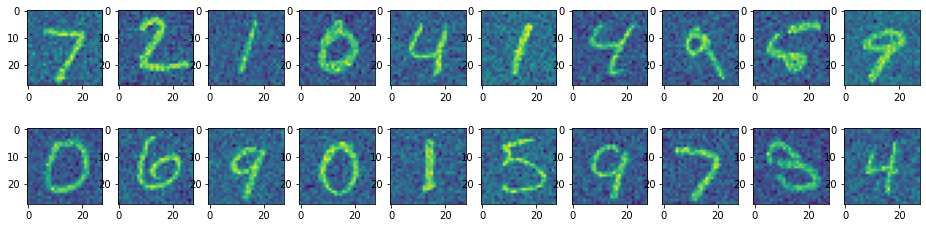

In [ ]:
visualize_data(X_test_noise[:20], 2,10)

In [ ]:
pred = dnse_auto_encoder.predict(X_test_noise[:20])

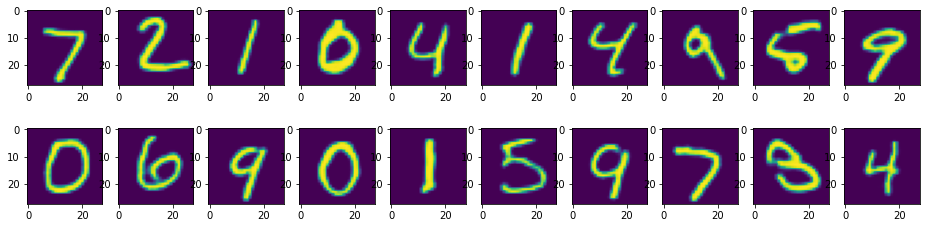

In [ ]:
visualize_data(pred, 2,10)